In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from functools import partial

In [3]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, r)

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

### Newton's second law for the constrained mass:
$$T-Mg=M\ddot r$$
$$T = M\ddot r + Mg$$

### Newton's second law (in polar form) for the swinging mass:
#### Radius:
$$a_r=gcos\theta - \frac{T}{m}=gcos\theta - \frac{Mg}{m} - \frac{M\ddot r}{m}=gcos\theta - \mu g - \mu \ddot r = \ddot r-r\dot\theta^2$$
$$\ddot r = \frac{g(cos\theta-\mu) + r\dot\theta^2}{1+\mu}$$
#### Angle:
$$a_\theta=-gsin\theta=r\ddot\theta+2\dot r \dot\theta$$
$$\ddot\theta = \frac{-gsin\theta-2\dot r \dot\theta}{r}$$

In [4]:
g = 9.81
# offsets for relevant quantities in the state array
R = 0
RDOT = 1
THETA = 2
THETADOT = 3

def ddt(mu, state, t):
    #some of these have been complicated with newton's 2nd law in polar coord form
    rdotdot = (g*(-mu + np.cos(state[THETA])) + state[R]*state[THETADOT]**2) / (1+mu)
    thetadotdot = (-g*np.sin(state[THETA])-2*state[RDOT]*state[THETADOT])/state[R]
    return np.array([state[RDOT],rdotdot,state[THETADOT],thetadotdot]) #r, rdot, theta, thetadot

def rk4(mu, state, t, dt):
    f0 = ddt(mu, state, t)
    f1 = ddt(mu, state+f0*(dt/2), t + dt/2)
    f2 = ddt(mu, state+f1*(dt/2), t + dt/2)
    f3 = ddt(mu, state+f2*(dt), t + dt)
    s_next = state + (f0 + 2 * f1 + 2 * f2 + f3) * dt / 6
    return s_next

In [5]:
def SAM(mu, init_state, t, show):
    states=[init_state] #this captures all necessary params: r, rdot, theta, thetadot
    times = [0]
    dt = 0.005
    threshold = 0.005

    for i in range(int(t/dt)):
        if(states[-1][0] < threshold * init_state[0]):
            print("Possible singularity. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        if(states[-1][0] > init_state[0]/threshold):
            print("Possible unbounded solution. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        states.append(rk4(mu, states[-1], times[-1], dt))
        times.append(times[-1] + dt)
        
    
    # transform and transpose
    states = np.array(states)
    states = states.transpose()

    if show:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.set_theta_zero_location("S")
        ax.plot(states[THETA], states[R], color='r', linewidth=1)
        plt.title("$\mu = %.3f$, $r_0 = %.3f$, $\\dot{r_0} = %.3f$, $\\theta_0 = %.3f$, $\\dot{\\theta_0} = %.3f$" % (mu, init_state[0], init_state[1], init_state[2], init_state[3]))
        ax.grid(True)
    return states

In [ ]:
SAM(1.667, np.array([2,0,np.pi/2,0]), 10, True) #known periodic orbit

In [ ]:
SAM(10, np.array([2,0,np.pi/2,0]), 10, True) #known singular orbit

In [ ]:
SAM(5, np.array([2,-3,0.1,0.7]), 10, True) #some initial velocity

In [15]:
DOT_SIZE = 90
DISTANCE_BETWEEN_PULLEYS = 0.5

def update(frame, dots, history, string, res, interval):
    # find string length such that remaining string length is not negative
    string_length = max(1.75, max(res[R]) + 0.1 + DISTANCE_BETWEEN_PULLEYS)
    
    # prevent t from going beyond the end
    t = frame*int(interval/5)
    t_end = len(res[0])-1
    t = min(t, t_end)

    # mutate path history    
    history.set_xdata(res[THETA][:t])
    history.set_ydata(res[R][:t])
    
    theta = res[THETA][t]
    r = res[R][t]
    
    # mutate swinging mass location
    swinging_dot = dots[0]
    swinging_dot.set_offsets([theta, r])
    
    # mutate vertical mass location
    vertical_dot = dots[1]
    remaining_string_length = string_length - DISTANCE_BETWEEN_PULLEYS - r
    
    alpha = np.arctan2(remaining_string_length, DISTANCE_BETWEEN_PULLEYS)
    angle = -np.pi/2 + alpha
    distance = np.sqrt(remaining_string_length**2 + DISTANCE_BETWEEN_PULLEYS**2)
    vertical_dot.set_offsets([angle, distance])
    
    # mutate string
    positions = np.array([[angle, distance],
        [-np.pi/2, DISTANCE_BETWEEN_PULLEYS],
        [0, 0],
        [theta, r]])
    string.set_data(np.transpose(positions))
    
    return [history, swinging_dot, vertical_dot, string]

def anim(mu, state, t, interval):
    # data for animation
    res = SAM(mu, state, t, False)
    
    # set up polar coords
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location("S")
    history = ax.plot(res[THETA], res[R], color='r', linewidth=1)[0] # past movement
    ax.grid(True)
    
    initial_theta = res[THETA][0]
    initial_r = res[R][0]
    
    swinging_dot = ax.scatter(initial_theta, initial_r, s=DOT_SIZE, c='black')
    vertical_dot = ax.scatter(initial_theta, initial_r, s=DOT_SIZE, c='blue')

    string = ax.plot(initial_theta, initial_r, color='gray', linewidth=1)[0] #idk why it returns it in a list

    ani = animation.FuncAnimation(fig=fig, func=partial(
        update, 
        history=history, 
        dots=[swinging_dot, vertical_dot],
        string=string,
        res=res, 
        interval=interval), frames=int(len(res[0])*5/interval), interval=interval)

    # filename checks and file creation
    i = 1
    filename = "example_mu" + str(mu) + ".gif"
    if os.path.exists(filename):
        while os.path.exists("example_mu%.3f_%s.gif" % (mu, i)):
            i += 1
        filename = "example_mu%.3f_%s.gif" % (mu, i)
    ani.save(filename=filename, writer="pillow", fps=int(1000/interval))

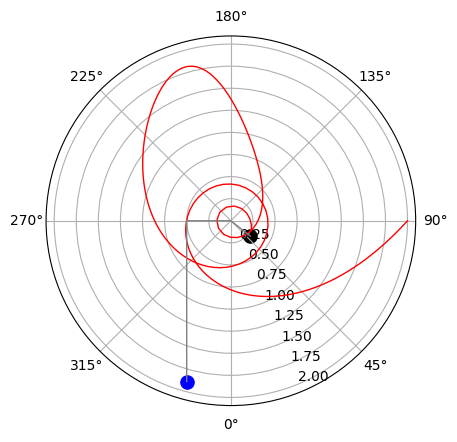

In [16]:
anim(mu=10.3, state=np.array([2, 0, np.pi/2, 0]), t=2, interval=30)